In [1]:
from factor_manager.momentum import Momentum
from factor_manager.doubleMA import DoubleMA
from utils.plot_tools import plot_corr, plot_pnl
from utils.cal_tools import *
from models.pca import rolling_pca
from models.run_models import rolling_run_models
import pandas as pd
import numpy as np
from loguru import logger

因子到仓位

In [2]:
def get_weights_from_prediction(preds: pd.Series):
    ''' 
    预测值需要保持在0-1之间
    '''
    return get_1D_array_from_series(preds.expanding().rank(pct=True))

def get_weights_from_rules(preds: pd.Series, trade_type='long_short', upper_bound=0, lower_bound=0):
    signal = get_1D_array_from_series(preds)
    if trade_type == 'long_only':
        weights = np.select([signal>upper_bound, signal<lower_bound, ~((signal>upper_bound) & (signal<lower_bound))],
                             [1, 0, 'follow'])
    elif trade_type == 'long_short':
        weights = np.select([signal>upper_bound, signal<lower_bound, ~((signal>upper_bound) & (signal<lower_bound))], 
                            [1, -1, 0])
    return weights

仓位到组合收益

In [3]:
def get_portfolio_rets(rets, weights):
    return get_1D_array_from_series(rets) * weights

对组合收益率的评估

In [4]:
def benchmark_evaluation(df_tags, eval_label):
    rets = df_tags['tag'].fillna(0)
    weights = 1
    portfolio_rets = get_portfolio_rets(rets, weights)
    
    evaluation = pd.Series({
                            'annualized return': get_annualized_rets(portfolio_rets),
                            'sharpe ratio': get_sharpe_ratio(portfolio_rets),
                            'win ratio': get_win_ratio(portfolio_rets),
                            'win per loss': get_win_per_loss(portfolio_rets),
                            }, name=eval_label).to_frame().T
    
    pnl = pd.Series((1 + portfolio_rets).cumprod() - 1, name=eval_label)
    return evaluation, pnl

def model_evaluation(df_tags, df_preds, weighted_type, eval_label):
    rets = df_tags.loc[df_preds.index].fillna(0)
    if weighted_type == 'prediction_based':
        weights = get_weights_from_prediction(df_preds)
    elif weighted_type == 'rule_based':
        weights = get_weights_from_rules(df_preds)
    
    turnover = get_buy_side_turnover(weights)
    portfolio_rets = get_portfolio_rets(rets, weights)

    evaluation = pd.Series({
                        'ts corr': ts_corr(df_preds, rets),
                        'ts rank corr': ts_rank_corr(df_preds, rets),
                        'turnover(buy side)': turnover,
                        'annualized return': get_annualized_rets(portfolio_rets),
                        'annualized costs': get_annualized_costs_by_turnover(turnover, costs_rate=0.00023),
                        'sharpe ratio': get_sharpe_ratio(portfolio_rets),
                        'win ratio': get_win_ratio(portfolio_rets),
                        'win per loss': get_win_per_loss(portfolio_rets),
                        }, name=eval_label).to_frame().T

    pnl = pd.Series((1 + portfolio_rets).cumprod() - 1, name=eval_label)
    return evaluation, pnl

Momentum因子测试

2023-12-26 15:18:41.810 | INFO     | data_manager.data_loader:load_data_by_file:15 - data loaded from /root/HappyQuantTest/happyquant/raw_data/stock_index/000016.parquet
2023-12-26 15:18:41.813 | INFO     | data_manager.data_loader:load_data_by_file:16 -                       0             1             2             3            4
ts_code       000016.SH     000016.SH     000016.SH     000016.SH    000016.SH
trade_date     20040102      20040105      20040106      20040107     20040108
close          1011.347      1060.801      1075.656      1086.303     1102.662
open            996.996      1008.279      1059.141      1075.562      1087.68
high           1021.568      1060.898      1086.694      1095.841     1108.291
low             993.892      1008.279      1059.095       1070.98     1082.509
pre_close        1000.0      1011.347      1060.801      1075.656     1086.303
change           11.347        49.454        14.855        10.647       16.359
pct_chg          1.1347        4.8

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Paralle

2023-12-26 15:18:57.160 | INFO     | __main__:<module>:53 -                    000016.SH_benchmark  \
annualized return             0.075339   
sharpe ratio                  0.291962   
win ratio                     0.502988   
win per loss                  1.042277   
ts corr                            NaN   
ts rank corr                       NaN   
turnover(buy side)                 NaN   
annualized costs                   NaN   

                                                   000016.SH_OLS  \
annualized return                                       0.023714   
sharpe ratio                                            0.153861   
win ratio                                               0.502922   
win per loss                                            1.021498   
ts corr             (-0.011327106418685971, 0.43303240648119257)   
ts rank corr         (-0.014579593333679674, 0.3128991465844306)   
turnover(buy side)                                      0.064456   
annualized costs 

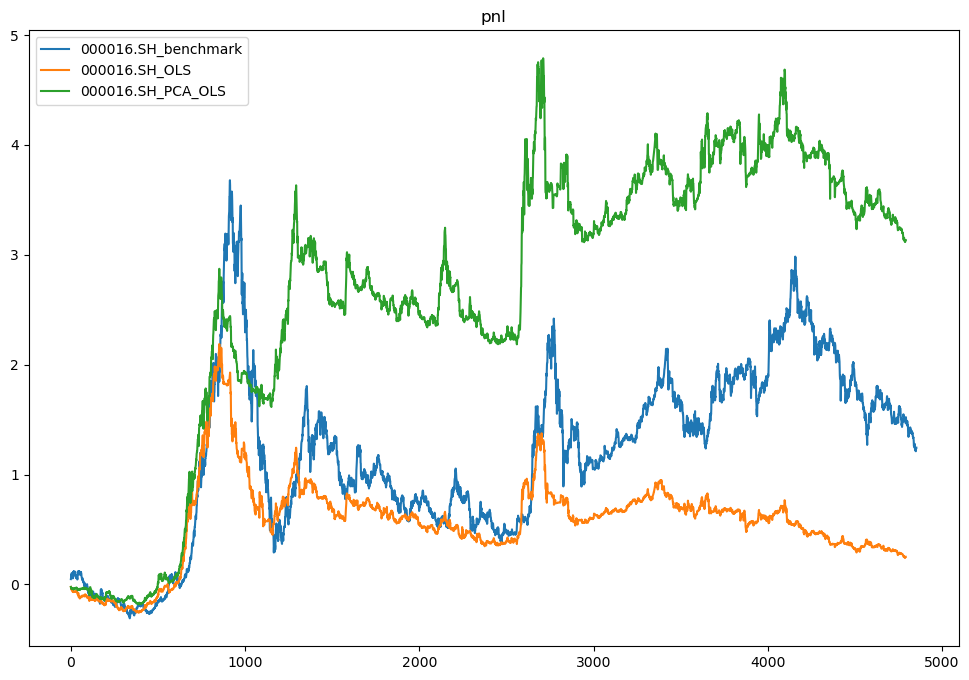

2023-12-26 15:18:57.466 | INFO     | data_manager.data_loader:load_data_by_file:15 - data loaded from /root/HappyQuantTest/happyquant/raw_data/stock_index/000300.parquet
2023-12-26 15:18:57.468 | INFO     | data_manager.data_loader:load_data_by_file:16 -                       0            1           2            3           4
ts_code       000300.SH    000300.SH   000300.SH    000300.SH   000300.SH
trade_date     20050104     20050105    20050106     20050107    20050110
close           982.794      992.564     983.174      983.958     993.879
open            994.769      981.577     993.331      983.045      983.76
high            994.769      997.323     993.788      995.711     993.959
low             980.658      979.877      980.33      979.812     979.789
pre_close        1000.0      982.794     992.564      983.174     983.958
change          -17.206         9.77       -9.39        0.784       9.921
pct_chg         -1.7206       0.9941      -0.946       0.0797      1.0083
vol  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 ta

2023-12-26 15:19:05.981 | INFO     | __main__:<module>:53 -                    000300.SH_benchmark  \
annualized return             0.100325   
sharpe ratio                  0.388583   
win ratio                      0.52538   
win per loss                  0.969576   
ts corr                            NaN   
ts rank corr                       NaN   
turnover(buy side)                 NaN   
annualized costs                   NaN   

                                                  000300.SH_OLS  \
annualized return                                      0.024773   
sharpe ratio                                           0.165625   
win ratio                                               0.52627   
win per loss                                           0.932697   
ts corr             (-0.03279961589697357, 0.02693611201154305)   
ts rank corr        (-0.006446634314029454, 0.6637553012152351)   
turnover(buy side)                                     0.060656   
annualized costs         

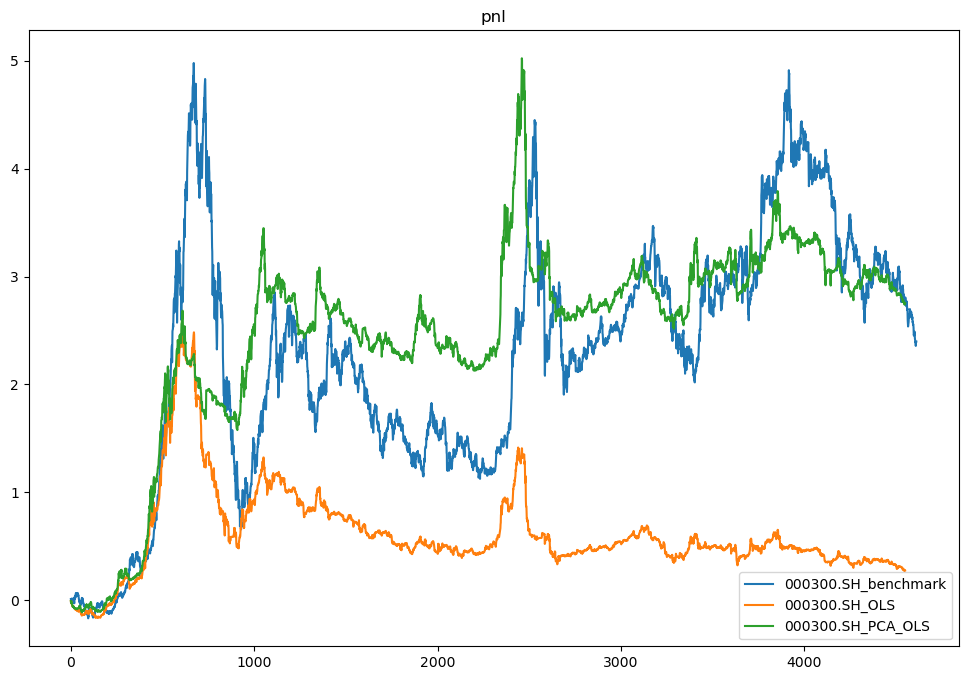

2023-12-26 15:19:06.271 | INFO     | data_manager.data_loader:load_data_by_file:15 - data loaded from /root/HappyQuantTest/happyquant/raw_data/stock_index/000905.parquet
2023-12-26 15:19:06.272 | INFO     | data_manager.data_loader:load_data_by_file:16 -                       0            1            2            3            4
ts_code       000905.SH    000905.SH    000905.SH    000905.SH    000905.SH
trade_date     20050104     20050105     20050106     20050107     20050110
close           986.927     1003.633      994.595      997.606     1006.337
open            996.682       986.57      1003.49      993.434      996.928
high            996.682     1008.855      1003.49       1009.0     1006.457
low             984.795      985.677      990.792      990.446      993.123
pre_close        1000.0      986.927     1003.633      994.595      997.606
change          -13.073       16.706       -9.038        3.011        8.731
pct_chg         -1.3073       1.6927      -0.9005       0.302

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0138s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 ta

2023-12-26 15:19:14.661 | INFO     | __main__:<module>:53 -                    000905.SH_benchmark  \
annualized return             0.135136   
sharpe ratio                  0.462162   
win ratio                     0.553796   
win per loss                  0.875335   
ts corr                            NaN   
ts rank corr                       NaN   
turnover(buy side)                 NaN   
annualized costs                   NaN   

                                                   000905.SH_OLS  \
annualized return                                       0.036281   
sharpe ratio                                            0.210504   
win ratio                                               0.554408   
win per loss                                             0.84045   
ts corr             (-0.02974317995830903, 0.044837074011015145)   
ts rank corr         (-0.002706190575944851, 0.8551960725078054)   
turnover(buy side)                                      0.063975   
annualized costs 

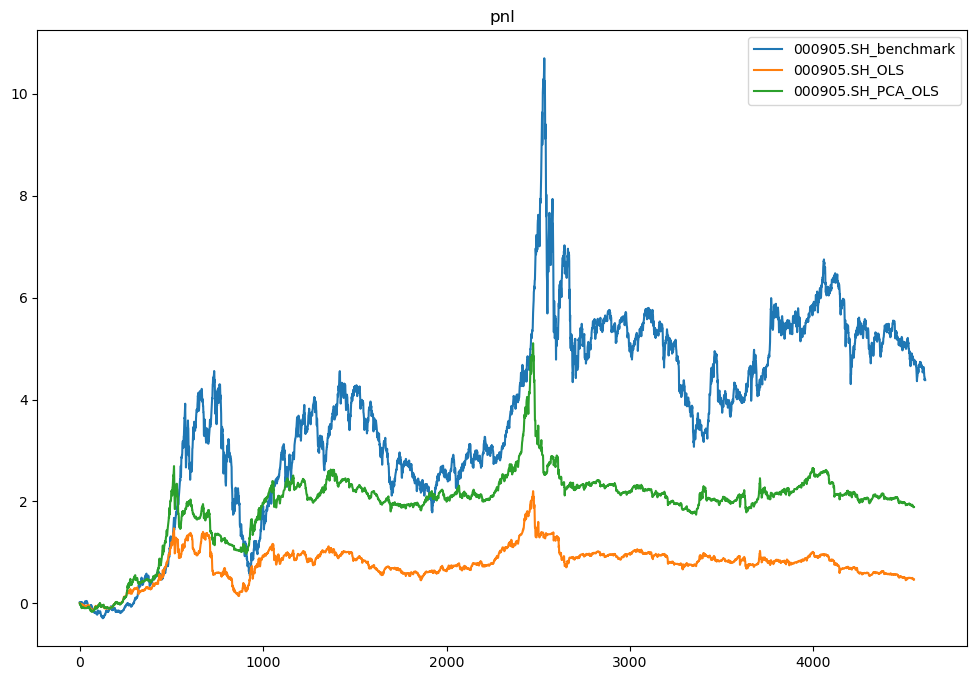

2023-12-26 15:19:14.912 | INFO     | data_manager.data_loader:load_data_by_file:15 - data loaded from /root/HappyQuantTest/happyquant/raw_data/stock_index/000852.parquet
2023-12-26 15:19:14.913 | INFO     | data_manager.data_loader:load_data_by_file:16 -                      0          1           2           3           4
ts_code      000852.SH  000852.SH   000852.SH   000852.SH   000852.SH
trade_date    20050104   20050105    20050106    20050107    20050110
close          989.984   1013.583    1005.465     1011.74    1023.638
open           996.278    989.873    1014.965    1005.515    1011.925
high           996.278   1018.261    1014.965    1021.706    1023.638
low            982.988    988.568    1001.213    1001.096    1007.802
pre_close       1000.0    989.984    1013.583    1005.465     1011.74
change         -10.016     23.599      -8.118       6.275      11.898
pct_chg        -1.0016     2.3838     -0.8009      0.6241       1.176
vol          494737.55  822661.44   732454.01

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0118s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 ta

2023-12-26 15:19:23.671 | INFO     | __main__:<module>:53 -                    000852.SH_benchmark  \
annualized return             0.142447   
sharpe ratio                  0.469628   
win ratio                     0.560304   
win per loss                  0.852614   
ts corr                            NaN   
ts rank corr                       NaN   
turnover(buy side)                 NaN   
annualized costs                   NaN   

                                                   000852.SH_OLS  \
annualized return                                       0.046073   
sharpe ratio                                            0.256682   
win ratio                                               0.561222   
win per loss                                            0.825138   
ts corr             (-0.027833179867830647, 0.06047720118243024)   
ts rank corr         (0.0011619492924952717, 0.9375446689881817)   
turnover(buy side)                                      0.066261   
annualized costs 

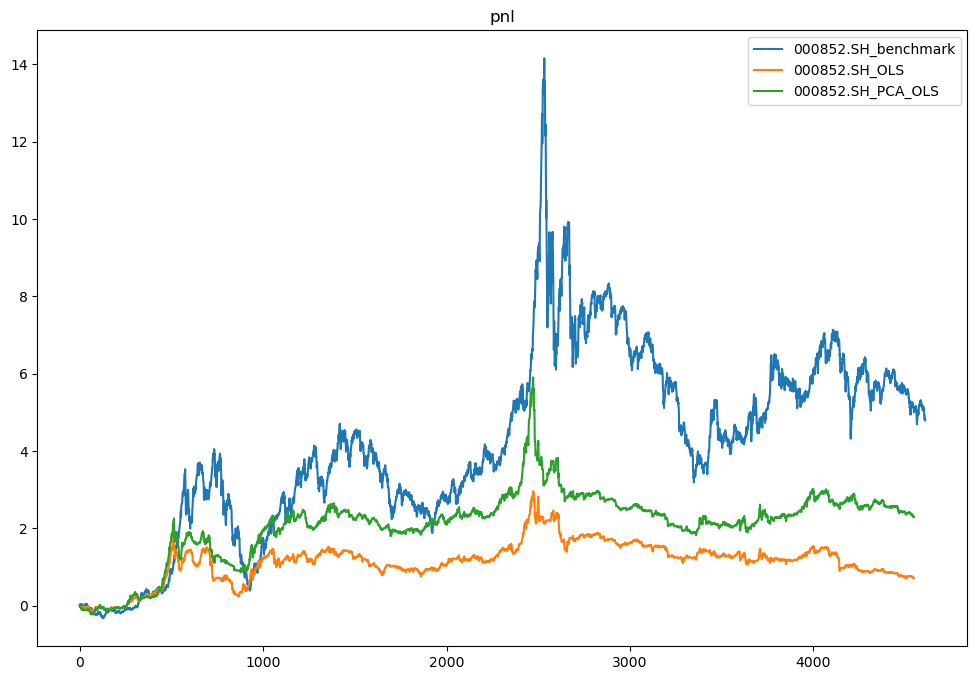

In [5]:
contract = ['000016.SH', '000300.SH', '000905.SH', '000852.SH']
for name in contract:
    list_evaluation = []
    list_pnl = []

    # Construct the data path based on the contract name
    data_path = f'{name[:-3]}.parquet'

    # Create an instance of the Momentum class
    mymm = Momentum(data_path)

    # Load raw data from the local storage
    mymm.load_raw_data_from_local()

    # Create a DataFrame for tags based on the raw data
    df_tags = mymm.df_raw['trade_date'].to_frame()
    df_tags['tag'] = (mymm.df_raw['close'] / mymm.df_raw['pre_close'] - 1).shift(-1)
    df_tags.set_index('trade_date', inplace=True)

    # Load factors from local storage
    mymm.load_factors_from_local()
    df_factors = mymm.df_factors.copy()
    df_factors.set_index('trade_date', inplace=True)

    # Plot correlation between tags and factors
    #plot_corr([df_tags, df_factors])

    # Benchmark
    eval_label = f'{name}_benchmark'
    evaluation, pnl = benchmark_evaluation(df_tags, eval_label)
    list_evaluation.append(evaluation)
    list_pnl.append(pnl)

    # Ordinary Least Squares (OLS)
    eval_label = f'{name}_OLS'
    df_preds = rolling_run_models(df_factors, df_tags, 60)
    evaluation, pnl = model_evaluation(df_tags, df_preds, weighted_type='prediction_based', eval_label=eval_label)
    list_evaluation.append(evaluation)
    list_pnl.append(pnl)
    
    # Principal Component Analysis (PCA)
    #df_pca = rolling_pca(df_factors, 60, 2)
    #plot_corr([df_tags, df_pca])

    # OLS with PCA
    eval_label = f'{name}_PCA_OLS'
    df_preds = rolling_run_models(df_factors, df_tags, 60, with_pca=True)
    evaluation, pnl = model_evaluation(df_tags, df_preds, weighted_type='prediction_based', eval_label=eval_label)
    list_evaluation.append(evaluation)
    list_pnl.append(pnl)

    df_evaluation = pd.concat(list_evaluation)
    logger.info(df_evaluation.T)

    # Plot profit and loss (P&L) for each model
    plot_pnl(list_pnl)

DoubleMA因子测试

2023-12-26 15:19:23.932 | INFO     | data_manager.data_loader:load_data_by_file:15 - data loaded from /root/HappyQuantTest/happyquant/raw_data/stock_index/000016.parquet
2023-12-26 15:19:23.935 | INFO     | data_manager.data_loader:load_data_by_file:16 -                       0             1             2             3            4
ts_code       000016.SH     000016.SH     000016.SH     000016.SH    000016.SH
trade_date     20040102      20040105      20040106      20040107     20040108
close          1011.347      1060.801      1075.656      1086.303     1102.662
open            996.996      1008.279      1059.141      1075.562      1087.68
high           1021.568      1060.898      1086.694      1095.841     1108.291
low             993.892      1008.279      1059.095       1070.98     1082.509
pre_close        1000.0      1011.347      1060.801      1075.656     1086.303
change           11.347        49.454        14.855        10.647       16.359
pct_chg          1.1347        4.8

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  14 ta

2023-12-26 15:19:27.884 | INFO     | __main__:<module>:38 -                    000016.SH_benchmark  \
annualized return             0.075339   
sharpe ratio                  0.291962   
win ratio                     0.502988   
win per loss                  1.042277   
ts corr                            NaN   
ts rank corr                       NaN   
turnover(buy side)                 NaN   
annualized costs                   NaN   

                                              000016.SH_factor_1  
annualized return                                       0.067407  
sharpe ratio                                             0.26172  
win ratio                                               0.501652  
win per loss                                            1.042154  
ts corr              (-0.008075712471380017, 0.5737723853426883)  
ts rank corr        (-0.0027888355590671363, 0.8459798737631239)  
turnover(buy side)                                      0.104634  
annualized costs         

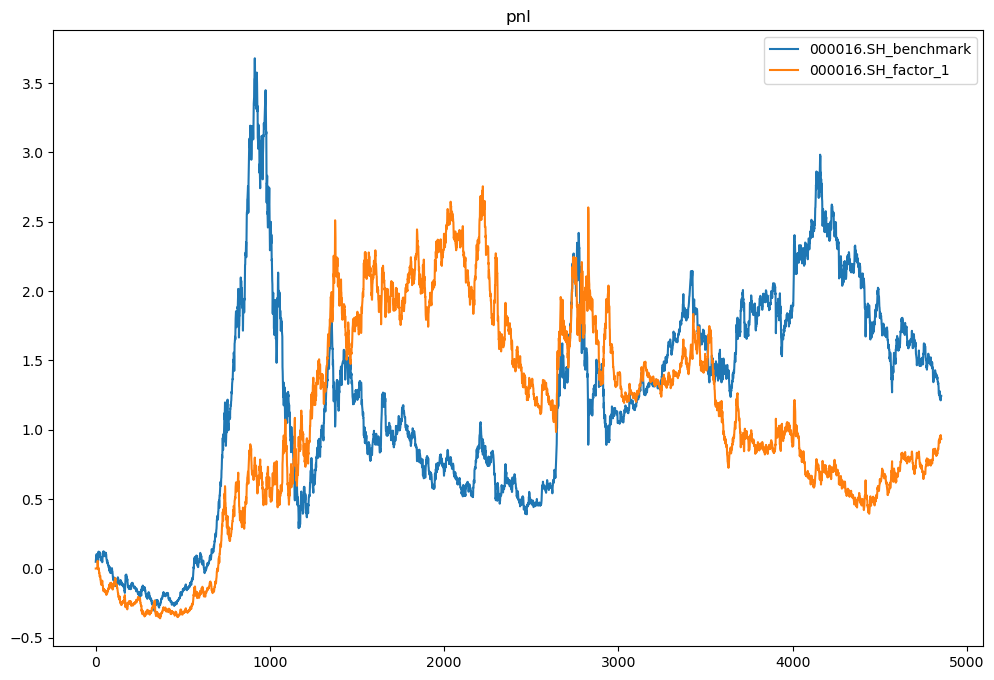

2023-12-26 15:19:28.139 | INFO     | data_manager.data_loader:load_data_by_file:15 - data loaded from /root/HappyQuantTest/happyquant/raw_data/stock_index/000300.parquet
2023-12-26 15:19:28.142 | INFO     | data_manager.data_loader:load_data_by_file:16 -                       0            1           2            3           4
ts_code       000300.SH    000300.SH   000300.SH    000300.SH   000300.SH
trade_date     20050104     20050105    20050106     20050107    20050110
close           982.794      992.564     983.174      983.958     993.879
open            994.769      981.577     993.331      983.045      983.76
high            994.769      997.323     993.788      995.711     993.959
low             980.658      979.877      980.33      979.812     979.789
pre_close        1000.0      982.794     992.564      983.174     983.958
change          -17.206         9.77       -9.39        0.784       9.921
pct_chg         -1.7206       0.9941      -0.946       0.0797      1.0083
vol  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0205s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 ta

2023-12-26 15:19:32.027 | INFO     | __main__:<module>:38 -                    000300.SH_benchmark  \
annualized return             0.100325   
sharpe ratio                  0.388583   
win ratio                      0.52538   
win per loss                  0.969576   
ts corr                            NaN   
ts rank corr                       NaN   
turnover(buy side)                 NaN   
annualized costs                   NaN   

                                             000300.SH_factor_1  
annualized return                                      0.069617  
sharpe ratio                                           0.269694  
win ratio                                              0.510106  
win per loss                                           1.008723  
ts corr              (0.009155915497747826, 0.5342240594277822)  
ts rank corr        (0.010998882330774663, 0.45524950991991875)  
turnover(buy side)                                     0.108413  
annualized costs                 

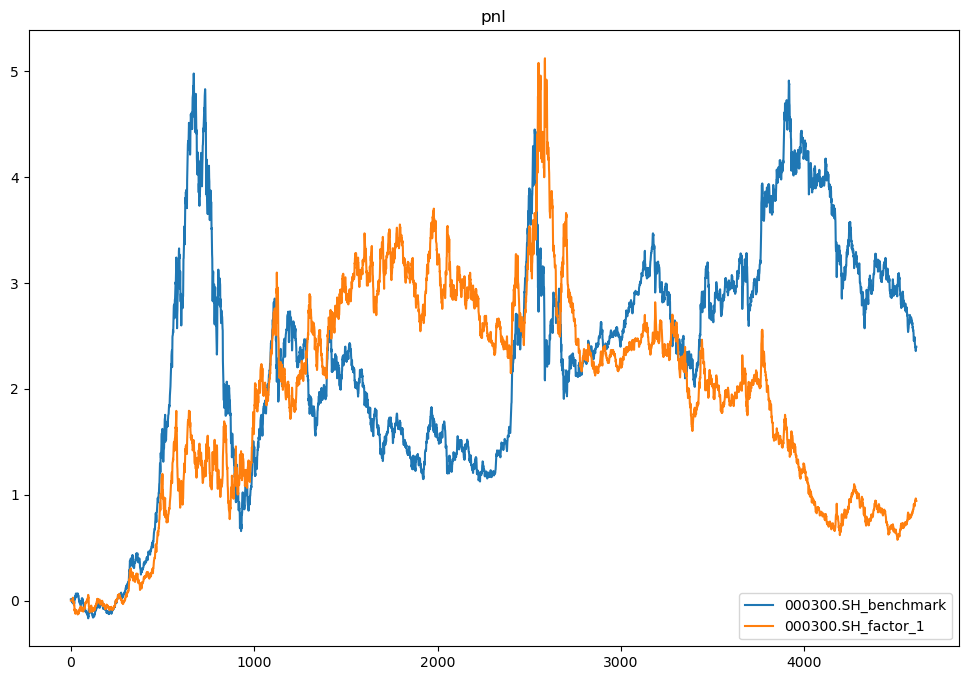

2023-12-26 15:19:32.270 | INFO     | data_manager.data_loader:load_data_by_file:15 - data loaded from /root/HappyQuantTest/happyquant/raw_data/stock_index/000905.parquet
2023-12-26 15:19:32.271 | INFO     | data_manager.data_loader:load_data_by_file:16 -                       0            1            2            3            4
ts_code       000905.SH    000905.SH    000905.SH    000905.SH    000905.SH
trade_date     20050104     20050105     20050106     20050107     20050110
close           986.927     1003.633      994.595      997.606     1006.337
open            996.682       986.57      1003.49      993.434      996.928
high            996.682     1008.855      1003.49       1009.0     1006.457
low             984.795      985.677      990.792      990.446      993.123
pre_close        1000.0      986.927     1003.633      994.595      997.606
change          -13.073       16.706       -9.038        3.011        8.731
pct_chg         -1.3073       1.6927      -0.9005       0.302

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0089s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 ta

2023-12-26 15:19:36.130 | INFO     | __main__:<module>:38 -                    000905.SH_benchmark  \
annualized return             0.135136   
sharpe ratio                  0.462162   
win ratio                     0.553796   
win per loss                  0.875335   
ts corr                            NaN   
ts rank corr                       NaN   
turnover(buy side)                 NaN   
annualized costs                   NaN   

                                             000905.SH_factor_1  
annualized return                                      0.074107  
sharpe ratio                                           0.253463  
win ratio                                              0.512497  
win per loss                                           0.995499  
ts corr             (0.02914511529703359, 0.047820089429743605)  
ts rank corr         (0.010414021182941985, 0.4795759712712031)  
turnover(buy side)                                      0.10928  
annualized costs                 

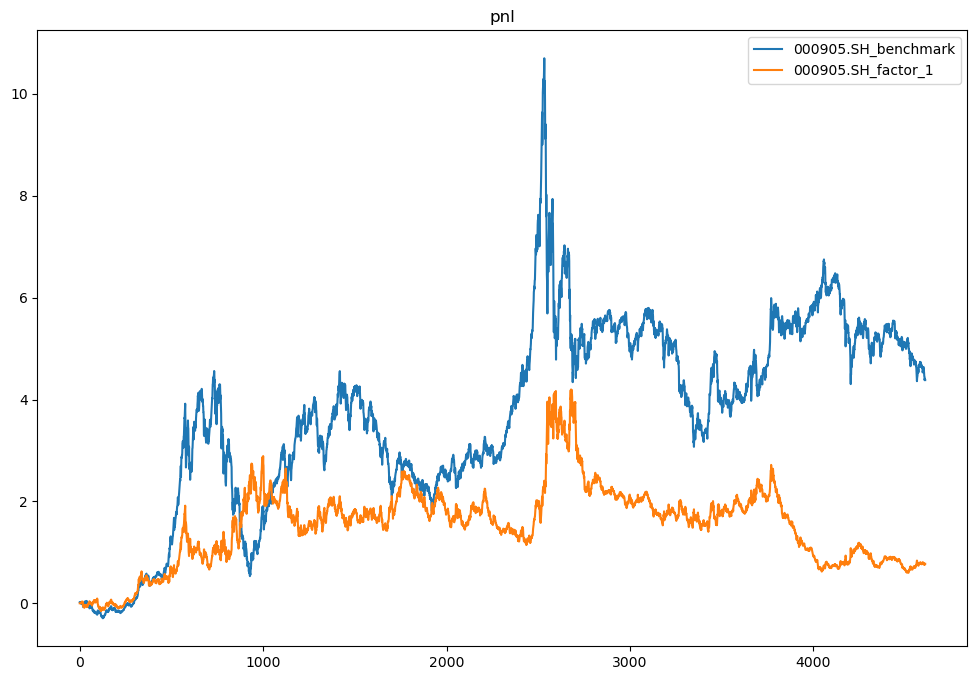

2023-12-26 15:19:36.389 | INFO     | data_manager.data_loader:load_data_by_file:15 - data loaded from /root/HappyQuantTest/happyquant/raw_data/stock_index/000852.parquet
2023-12-26 15:19:36.391 | INFO     | data_manager.data_loader:load_data_by_file:16 -                      0          1           2           3           4
ts_code      000852.SH  000852.SH   000852.SH   000852.SH   000852.SH
trade_date    20050104   20050105    20050106    20050107    20050110
close          989.984   1013.583    1005.465     1011.74    1023.638
open           996.278    989.873    1014.965    1005.515    1011.925
high           996.278   1018.261    1014.965    1021.706    1023.638
low            982.988    988.568    1001.213    1001.096    1007.802
pre_close       1000.0    989.984    1013.583    1005.465     1011.74
change         -10.016     23.599      -8.118       6.275      11.898
pct_chg        -1.0016     2.3838     -0.8009      0.6241       1.176
vol          494737.55  822661.44   732454.01

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0181s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  14 ta

2023-12-26 15:19:40.679 | INFO     | __main__:<module>:38 -                    000852.SH_benchmark  \
annualized return             0.142447   
sharpe ratio                  0.469628   
win ratio                     0.560304   
win per loss                  0.852614   
ts corr                            NaN   
ts rank corr                       NaN   
turnover(buy side)                 NaN   
annualized costs                   NaN   

                                              000852.SH_factor_1  
annualized return                                       0.060897  
sharpe ratio                                            0.200801  
win ratio                                               0.516409  
win per loss                                             0.97029  
ts corr             (0.04352107849259284, 0.0031178895636365667)  
ts rank corr         (0.010749477403727848, 0.46553726837101195)  
turnover(buy side)                                      0.106678  
annualized costs         

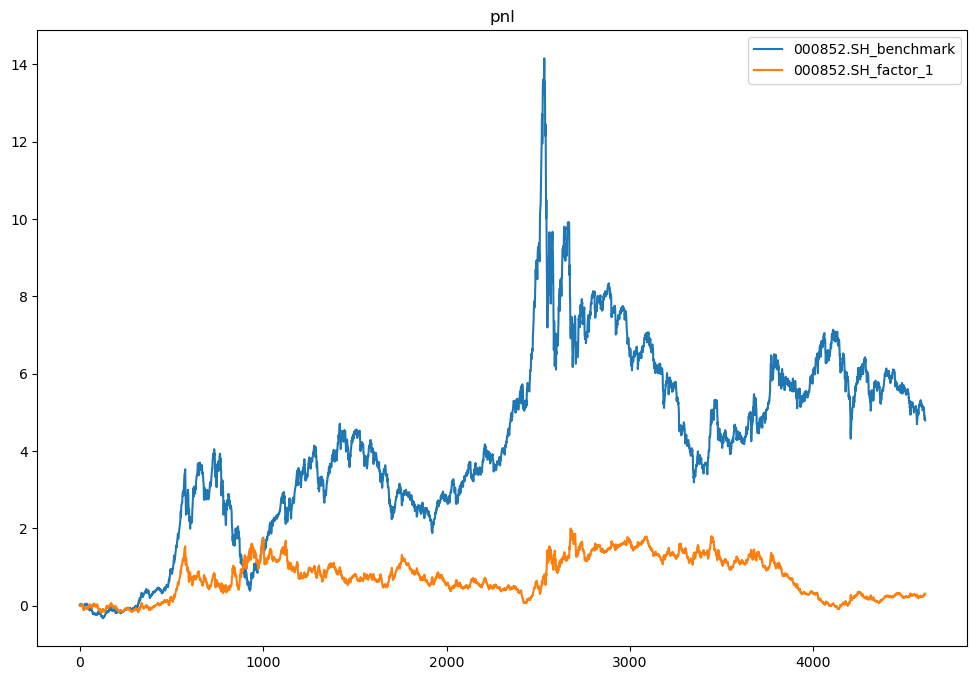

In [6]:
contract = ['000016.SH', '000300.SH', '000905.SH', '000852.SH']
for name in contract:
    list_evaluation = []
    list_pnl = []

    # Construct the data path based on the contract name
    data_path = f'{name[:-3]}.parquet'

    # Create an instance of the Momentum class
    mymm = DoubleMA(data_path)

    # Load raw data from the local storage
    mymm.load_raw_data_from_local()

    # Create a DataFrame for tags based on the raw data
    df_tags = mymm.df_raw['trade_date'].to_frame()
    df_tags['tag'] = (mymm.df_raw['close'] / mymm.df_raw['pre_close'] - 1).shift(-1)
    df_tags.set_index('trade_date', inplace=True)

    # Load factors from local storage
    mymm.load_factors_from_local()
    df_factors = mymm.df_factors.copy()
    df_factors.set_index('trade_date', inplace=True)
    
    # benchmark
    eval_label = f'{name}_benchmark'
    evaluation, pnl = benchmark_evaluation(df_tags, eval_label)
    list_evaluation.append(evaluation)
    list_pnl.append(pnl)

    eval_label = f'{name}_factor_1'
    df_preds = rolling_run_models(df_factors, df_tags, 60)
    evaluation, pnl = model_evaluation(df_tags, df_factors.iloc[:, 0].dropna(), weighted_type='rule_based', eval_label=eval_label)
    list_evaluation.append(evaluation)
    list_pnl.append(pnl)

    df_evaluation = pd.concat(list_evaluation)
    logger.info(df_evaluation.T)

    # Plot profit and loss (P&L) for each model
    plot_pnl(list_pnl)